__Notification__: This notebook show the model evaludation results of the models using MACCS fingerprint

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn lib
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# 1. Import data

In [2]:
train_test_path = "../../data_for_modeling/train_test_data/HDAC2_train_test_data_final.xlsx"
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')
validation_dataset = pd.read_excel(train_test_path, sheet_name='validation_dataset')

In [3]:
print(len(train_dataset), len(test_dataset), len(validation_dataset))

2016 281 504


In [4]:
train_dataset.head()

,CID,SMILES,AVG_IC50_nM,FINAL_LABEL,ZBG Classified
0,44138033,COC(=O)c1ccc(CO/N=C/c2ccc(/C=C/C(=O)NO)cc2)cc1,15800.0,Inactive,1
1,164616411,CC[C@H](NC(=O)C1CN(C)C1)c1ncc(-c2cc3ccccc3nc2O...,50000.0,Inactive,15
2,135357843,O=C(NO)c1ccc(Cn2nnnc2-c2cccs2)cc1,3698.0,Inactive,1
3,142506189,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(NCc3ccc(C(...,7173.0,Inactive,1
4,155537112,CN(C)c1ccc(C(=O)N(CC(=O)NCc2ccccc2)Cc2ccc(C(=O...,283.0,Inactive,4


In [5]:
test_dataset.head()

,CID,SMILES,AVG_IC50_nM,FINAL_LABEL,ZBG Classified
0,89183110,CN1CCC(CC1=O)C(=O)Nc1cc(ccc1N)C1=CCCCC1,17550.0,Inactive,4
1,118005717,O=C(NO)c1cnc(NC2(c3ccccc3)CCN(C(=O)Nc3ccccc3)C...,34.0,Active,1
2,60145787,O=C(N[C@@H](CCCCCCSSc1ccccn1)C(=O)OCc1ccc2cccc...,40.3,Active,3
3,122192003,C\C=C1/NC(=O)[C@H](CS)NC(=O)[C@H](NC(=O)C[C@H]...,1.4,Active,3
4,87718892,O=C(NO)c1cnc(NC2(c3ccc(Cl)cc3)CC2)nc1,40.0,Active,1


# 2. Model training with MACCS fingerprint

## MACCS fingerprint encoding

In [7]:
#MACCS
from tqdm import tqdm

def maccs_fpts(data):
    Maccs_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = MACCSkeys.GenMACCSKeys(mol)
            mfpts = np.array(fpts)
            Maccs_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Maccs_fpts)

#maccs
def morgan_fpts(data):
    Morgan_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
            mfpts = np.array(fpts)
            Morgan_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Morgan_fpts)

In [8]:
X_Train = maccs_fpts(train_dataset['SMILES'])
X_Test = maccs_fpts(test_dataset['SMILES'])
X_Validation = maccs_fpts(validation_dataset['SMILES'])

Progress:   7%|▋         | 147/2016 [00:00<00:01, 1461.31it/s]

Progress: 100%|██████████| 504/504 [00:00<00:00, 1429.98it/s]


In [9]:
#y data
y_Train = np.array(train_dataset['FINAL_LABEL'])
y_Test = np.array(test_dataset['FINAL_LABEL'])
y_Validation = np.array(validation_dataset['FINAL_LABEL'])

#Original data
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

#One-hot encoder
import sklearn.preprocessing as preprocessing
y_Train = preprocessing.LabelEncoder().fit_transform(y_Train)
y_Test = preprocessing.LabelEncoder().fit_transform(y_Test)
y_Validation = preprocessing.LabelEncoder().fit_transform(y_Validation)
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

['Inactive' 'Inactive' 'Inactive' 'Inactive' 'Inactive']
['Inactive' 'Active' 'Active' 'Active' 'Active']
['Inactive' 'Active' 'Inactive' 'Inactive' 'Inactive']
[1 1 1 1 1]
[1 0 0 0 0]
[1 0 1 1 1]


## Model training

__Random Forest Classifier__

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_maccs = RandomForestClassifier(n_estimators=26, criterion='entropy', random_state=0)
rf_maccs.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', n_estimators=26, random_state=0)

__K Nearest Neighbor__

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn_maccs = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_maccs.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [12]:
from sklearn.svm import SVC
svm_maccs = SVC(kernel='rbf', probability=True, random_state=0)
svm_maccs.fit(X_Train, y_Train)

SVC(probability=True, random_state=0)

__XGBoost__

In [13]:
from xgboost import XGBClassifier
bst_maccs = XGBClassifier(objective='binary:logistic', tree_method="hist", max_depth=2)
bst_maccs.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Model evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return ac, precision, recall, mcc, f1

def me_result(cm, model_name):
    cm_string = "Confusion matrix of " + model_name
    print(cm_string)
    print(cm)
    ac, se, sp, mcc, f1 = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [['Model', 'AC', 'SE', 'SP', 'MCC', 'F1'], [model_name, ac, se, sp, mcc, f1]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

### 1. Calculate all the evaluation metrics on test and validation dataset

In [ ]:
X_Total = np.concatenate((X_Train, X_Validation), axis=0)
y_Total = np.concatenate((y_Train, y_Validation), axis=0)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

cols = ['Model', 'Fingerprint', 
        '10-fold cross validation AC', 'Test-set Accuracy', 'Test-set Precision', 'Test-set Recall', 'Test-set MCC', 'Test-set F1', 'Test-set AUC', 
        'Training error', 'Test error', 'Validation error',
        'Validation-set Accuracy', 'Validation-set Precision', 'Validation-set Recall', 'Validation-set MCC', 'Validation-set F1', 'Validation-set AUC']

model_result = pd.DataFrame(columns=cols)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

for model_name in ['KNN', 'RF', 'SVM', 'XgBoost']:
    cv_scores = None
    y_pred_test = None
    y_pred_train = None
    y_pred_validation = None
    model = None
    
    if model_name == 'KNN':
        model = knn_maccs
    elif model_name == 'RF':
        model = rf_maccs
    elif model_name == 'SVM':
        model = svm_maccs
    elif model_name == 'XgBoost':
        model = bst_maccs
    else:
        print("Error")
    
    #Cross validation
    cv_scores = cross_val_score(model, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
    
     #Test set
    y_pred_test = model.predict(X_Test)
    y_proba_test = model.predict_proba(X_Test)[:, 1]
    auc_score_test = roc_auc_score(y_Test, y_proba_test)
    cm_test = confusion_matrix(y_Test, y_pred_test)
    test_ac, test_precision, test_recall, test_mcc, test_f1 = model_evaluation_calculation(cm_test)
    test_error = 1 - test_ac
    
    #validation set
    y_pred_validation = model.predict(X_Validation)
    y_proba_validation = model.predict_proba(X_Validation)[:, 1]
    auc_score_validation = roc_auc_score(y_Validation, y_proba_validation)
    cm_validation = confusion_matrix(y_Validation, y_pred_validation)
    validation_ac, validation_precision, validation_recall, validation_mcc, validation_f1 = model_evaluation_calculation(cm_validation)
    validation_error = 1 - validation_ac
    
    #train set
    y_pred_train = model.predict(X_Train)
    y_proba_train = model.predict_proba(X_Train)[:, 1]
    auc_score_train = roc_auc_score(y_Train, y_proba_train)
    cm_train = confusion_matrix(y_Train, y_pred_train)
    train_ac, _, _, _, _ = model_evaluation_calculation(cm_train)
    train_error = 1 - train_ac
    
    row_result = pd.DataFrame([[model_name, "MACCS", 
                                np.mean(cv_scores)*100, test_ac*100, test_precision*100, test_recall*100, test_mcc*100, test_f1*100, auc_score_test*100, 
                                train_error*100, test_error*100, validation_error*100,
                                validation_ac*100, validation_precision*100, validation_recall*100, validation_mcc*100, validation_f1*100, auc_score_validation*100]], 
                                columns=cols)
    
    model_result = pd.concat([model_result, row_result], ignore_index=True)

In [ ]:
model_result.head()

,Model,Fingerprint,10-fold cross validation AC,Test-set Accuracy,Test-set Precision,Test-set Recall,Test-set MCC,Test-set F1,Test-set AUC,Training error,Test error,Validation error,Validation-set Accuracy,Validation-set Precision,Validation-set Recall,Validation-set MCC,Validation-set F1,Validation-set AUC
0,KNN,MACCS,82.063492,83.629893,79.120879,72.727273,63.585512,75.789474,89.647195,12.648810,16.370107,17.460317,82.539683,69.811321,73.509934,59.058578,71.612903,86.581898
1,RF,MACCS,83.412698,85.765125,74.725275,80.000000,67.010066,77.272727,90.011567,2.083333,14.234875,15.674603,84.325397,67.295597,79.850746,62.553154,73.037543,91.152128
2,SVM,MACCS,80.952381,81.138790,57.142857,78.787879,54.943035,66.242038,87.371313,15.773810,18.861210,18.650794,81.349206,53.459119,80.952381,54.538029,64.393939,86.663932
3,XgBoost,MACCS,80.119048,80.782918,60.439560,75.342466,54.385596,67.073171,84.658762,16.121032,19.217082,19.444444,80.555556,54.716981,76.991150,52.570892,63.970588,84.582080


### 2. ROC Curves

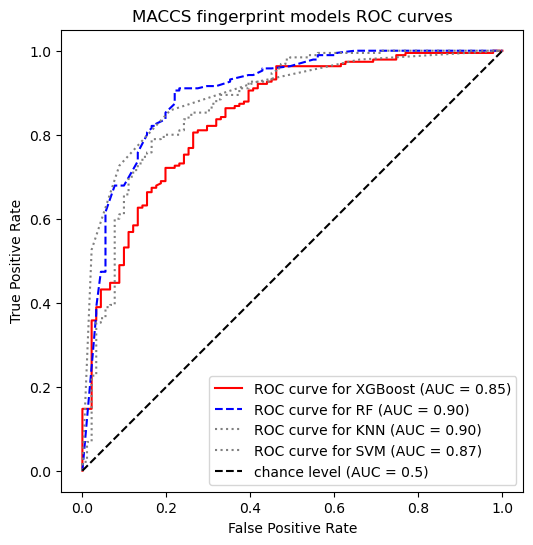

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=bst_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    linestyle="solid",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=rf_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    linestyle="dashed",
    color='blue',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=knn_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='gray',
    linestyle='dotted',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    linestyle='dotted',
    color='gray',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MACCS fingerprint models ROC curves")
plt.legend()
plt.show()

In [20]:
knn_y_proba = knn_maccs.predict_proba(X_Test)[:, 1]
rf_y_proba = rf_maccs.predict_proba(X_Test)[:, 1]
svm_y_proba = svm_maccs.predict_proba(X_Test)[:, 1]
bst_y_proba = bst_maccs.predict_proba(X_Test)[:, 1]

knn_auc_score = roc_auc_score(y_Test, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.8964719491035281 0.9001156737998843 0.8737131289762868 0.8465876229034124
